26.03283333381017 46.1125


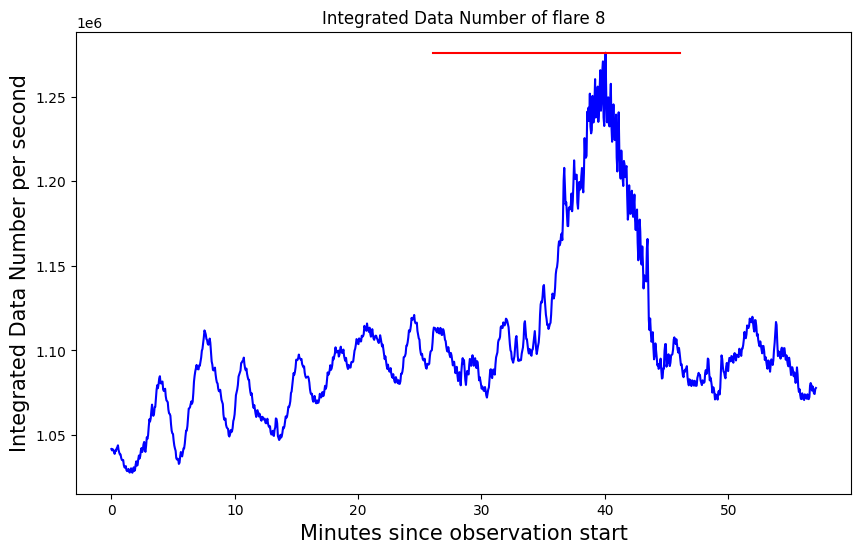

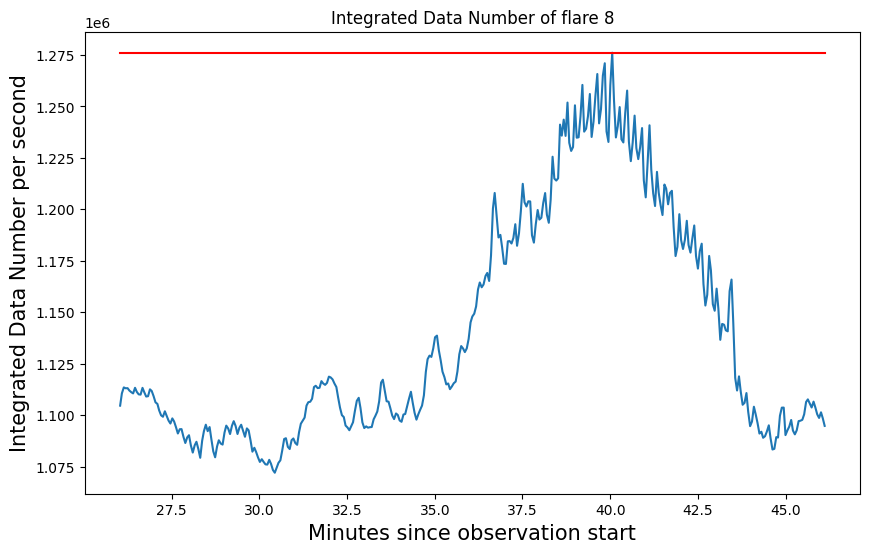

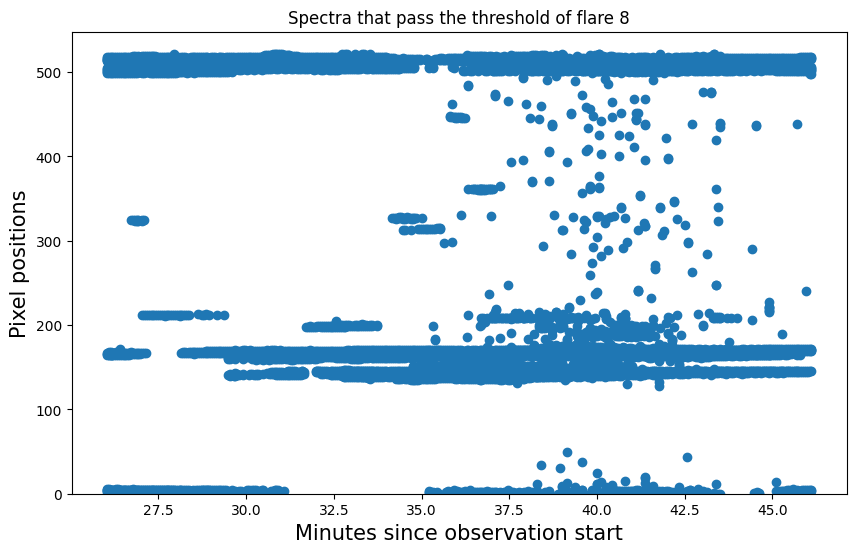

490 868
17.320333333810172 37.453166667620344


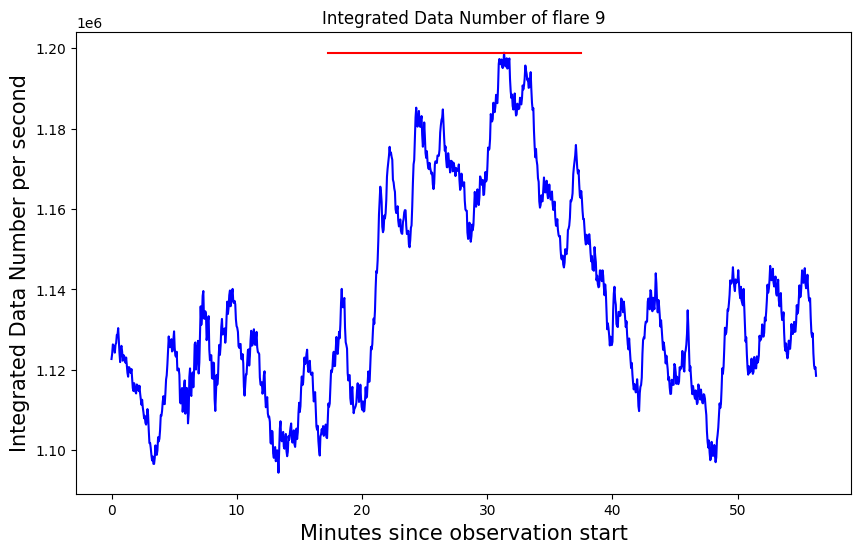

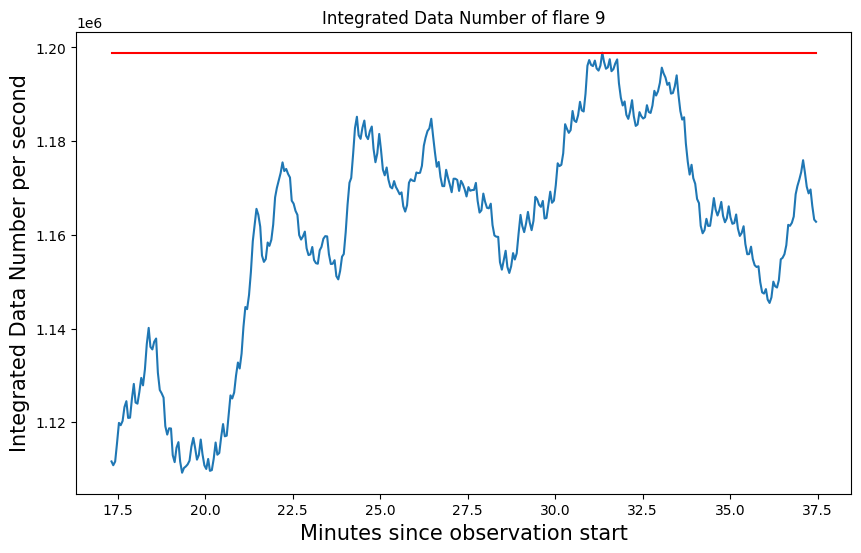

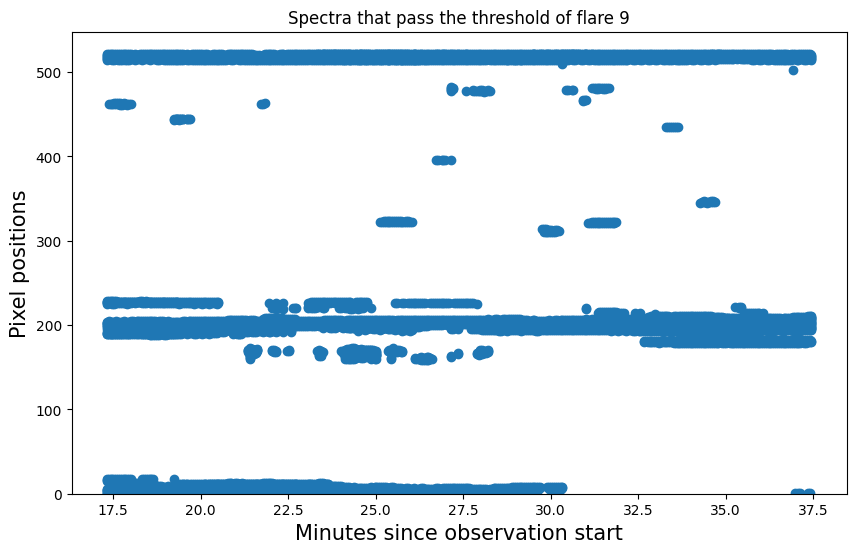

326 705
24.08283333381017 44.44266666571299


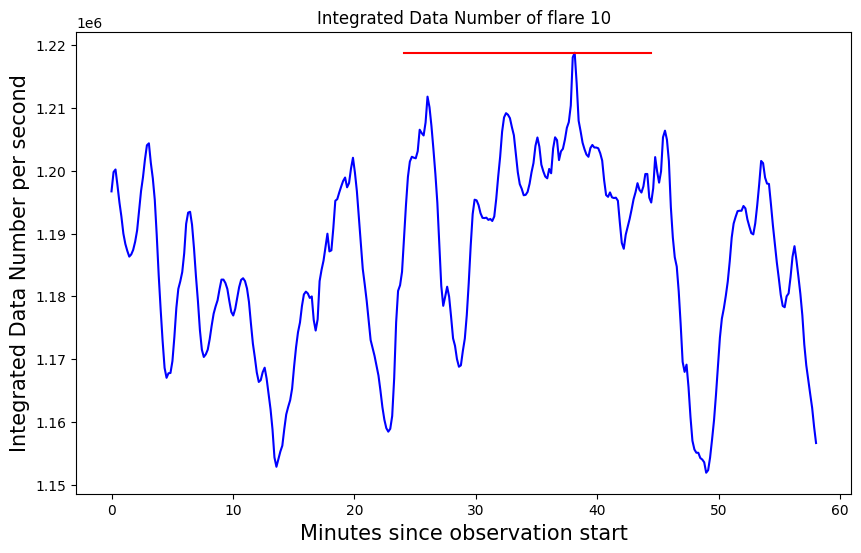

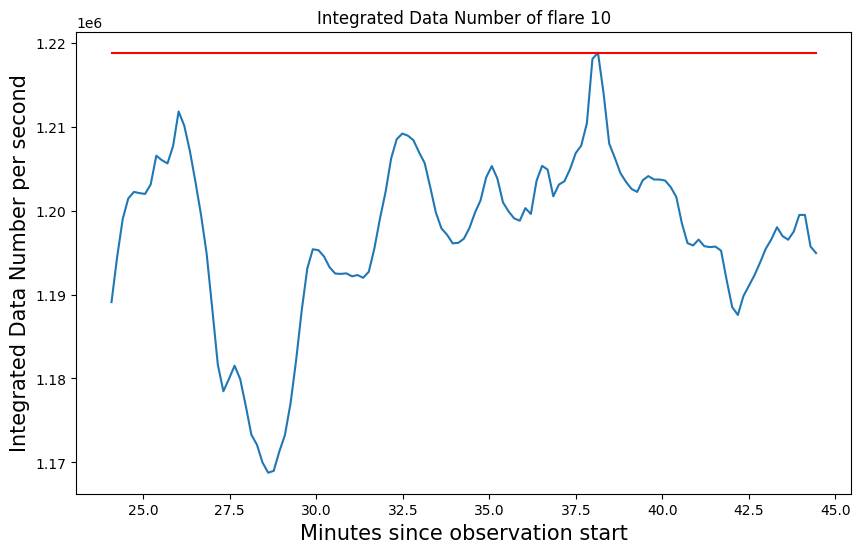

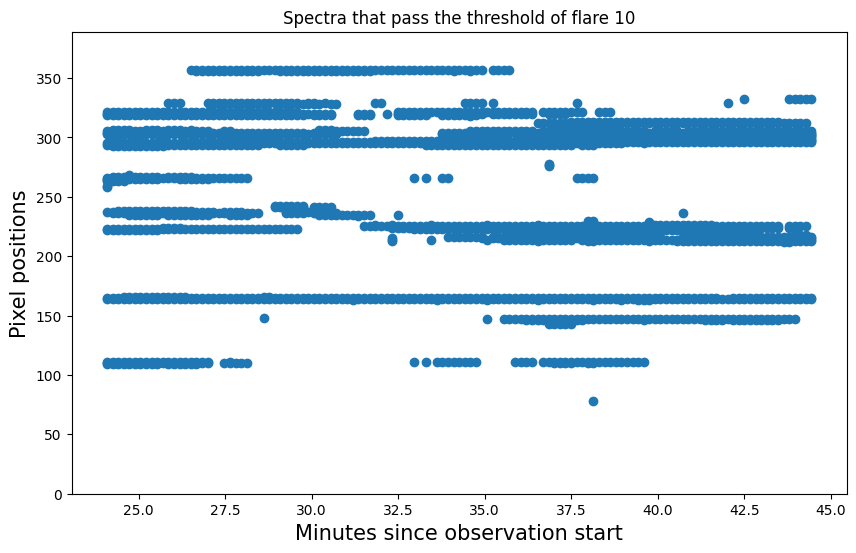

149 275
34.71666666666667 55.32966666618983


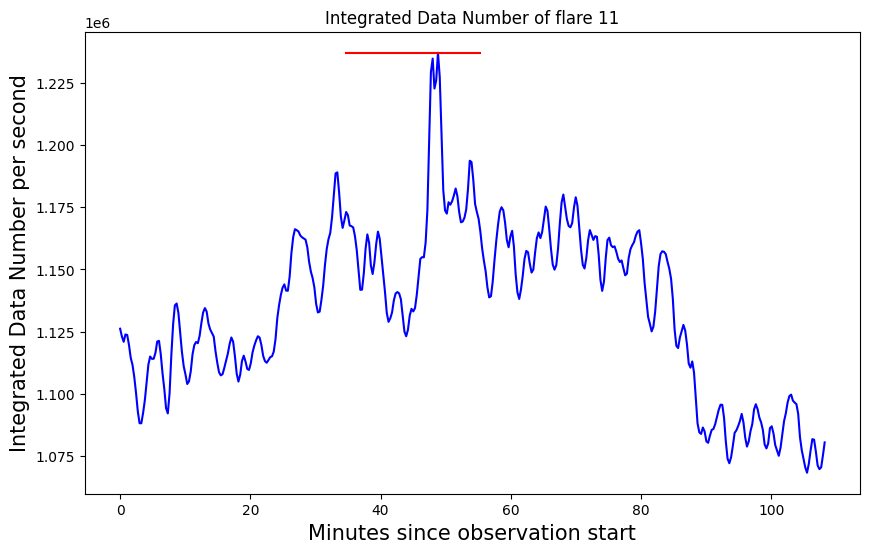

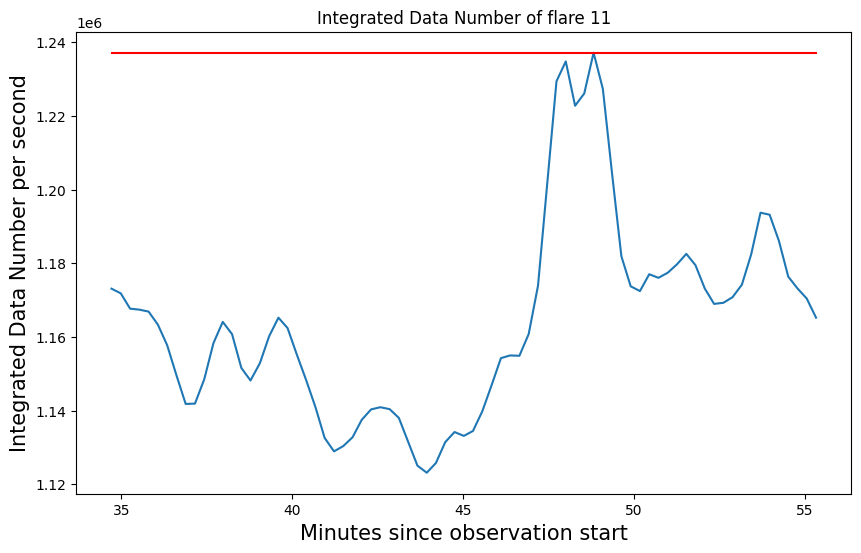

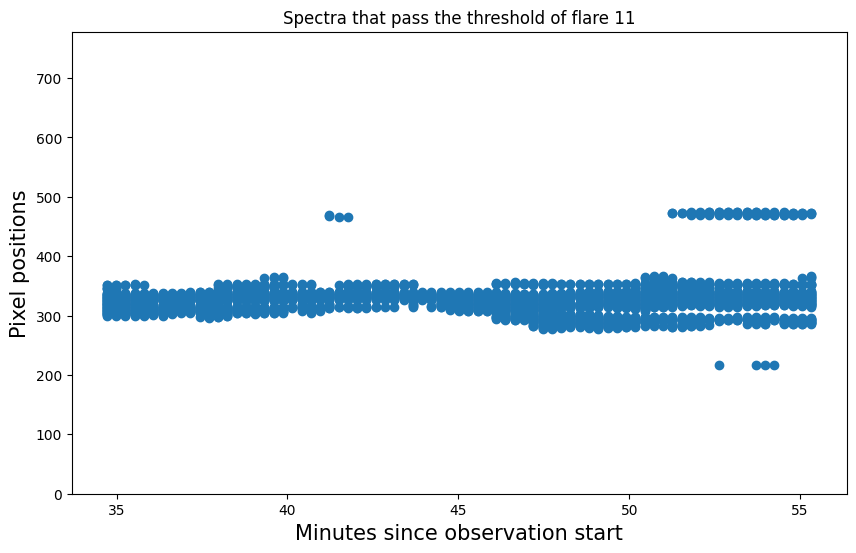

128 204
6.956166664759318 26.991333333651223


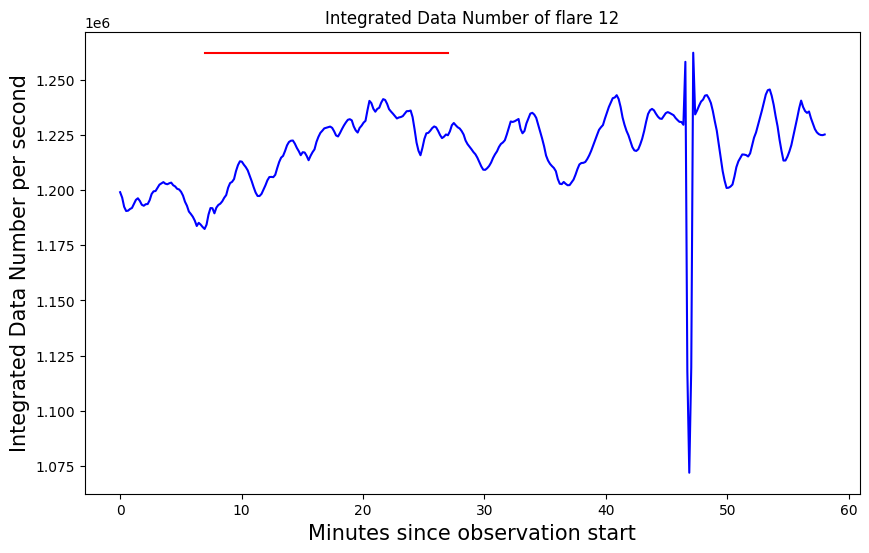

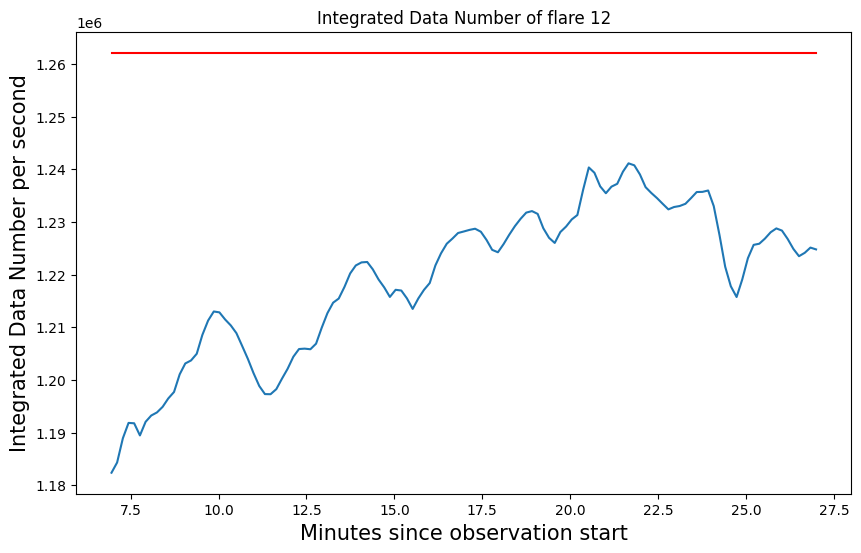

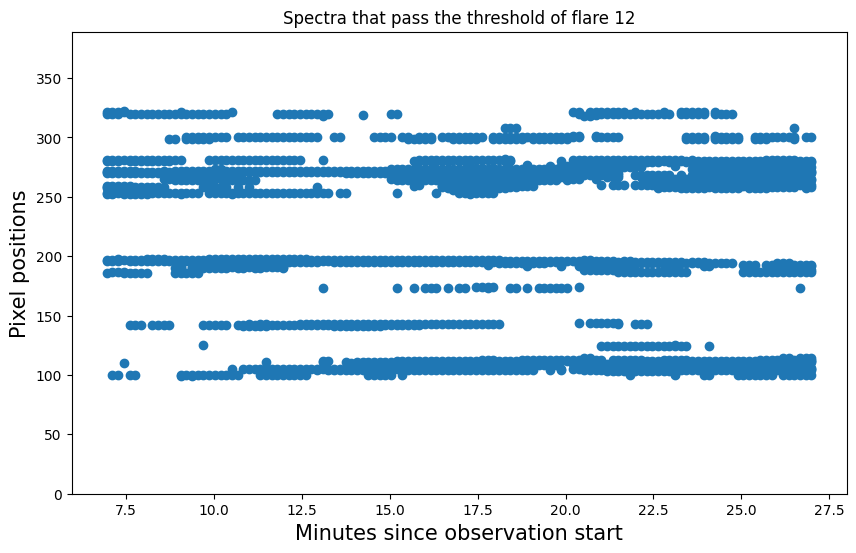

43 167


In [23]:
import matplotlib.pyplot as plt
import irisreader as ir
from irisreader import observation
ir.config.verbosity_level=0
import numpy as np
import os

def savgol_coeffs(window_size, poly_order):
    half_window = (window_size - 1) // 2
    # Precompute matrix for polynomial coefficients
    A = np.zeros((window_size, poly_order + 1))
    for i in range(-half_window, half_window + 1):
        A[i + half_window, :] = [i**j for j in range(poly_order + 1)]
    # Compute the pseudo-inverse of matrix A
    A_pinv = np.linalg.pinv(A)
    # The filter coefficients are the first row of the pseudo-inverse
    return A_pinv[0]

def apply_savgol_filter(data, window_size, poly_order):
    if window_size % 2 == 0 or window_size < 1:
        raise ValueError("window_size must be a positive odd number")
    if poly_order >= window_size:
        raise ValueError("poly_order must be less than window_size")
    
    # Get the filter coefficients
    coeffs = savgol_coeffs(window_size, poly_order)
    
    half_window = (window_size - 1) // 2
    data_padded = np.pad(data, (half_window, half_window), mode='edge')
    
    filtered_data = np.convolve(data_padded, coeffs, mode='valid')
    
    return filtered_data

def Find_Time(path, n, obs, fsize):
    hdrs = obs.raster("Mg II k").headers
    lambda_min = hdrs[0]["WAVEMIN"] + 0.00001
    lambda_max = hdrs[0]["WAVEMAX"] - 0.00001
    exptime = obs.raster("Mg II k").get_exptimes()
    ras_time = obs.raster("Mg II k").get_timestamps(0)
    Time = []
    a = obs.raster("Mg II k")
    DataNumber = []
    for t in range(a.shape[0]):
        time = ras_time[t] - ras_time[0]
        Time.append(time/60)
        interpolated_image = a.get_interpolated_image_step( t, lambda_min, lambda_max, n_breaks=100 )
        DN = 0
        #Sum over all y-pixels in the timestep t
        for y in range(interpolated_image.shape[0]):
            # Extract the spectra corresponding to the current 't' and 'y'
            b = interpolated_image[y]/exptime[t]
            #Sum the spectra while removing illogical negative data
            for p in range(len(b)):
                if b[p] >= 0:
                    DN += b[p]
            '''
            DN += sum(b)
            '''
        DataNumber.append(DN)
    # Find the maximum value for all t
    Max = np.min(DataNumber)
    Peak = 0
    #Filter for outlier ts (a flare does not occur in a single timestep)
    y = apply_savgol_filter(DataNumber, 5, 2)
    #Find and store t of peak
    for i in range(len(y)):
        if y[i] > Max and y[i] != float('inf'):
            Peak = i
            Peaktime = Time[i]
            Max = y[i]
    t_start0 = t_end0 = Peak
    dif = 0
    #Extract time sequence of the flare, adapted to the different observations
    while dif < 14:
        t_start0 -= 1
        dif = Peaktime - Time[t_start0] 
        if t_start0 <= 0:
            dif = 10
            t_start0 = 0
    dif = 0
    while dif < 6:
        dif = Time[t_end0] - Peaktime
        t_end0 += 1
        if t_end0 >= len(Time):
            dif = 20
            t_end0 = len(Time) - 1
    #Flare 1 (X1)
    if path == '20140910_112825_3860259453':
        dif = 0
        t_start0 = t_end0 = Peak
        while dif < 8:
            dif = Peaktime - Time[t_start0] 
            t_start0 -= 1
            if t_start0 <= 0:
                dif = 10
                t_start0 = 0
        dif = 0
        while dif < 12:
            dif = Time[t_end0] - Peaktime
            t_end0 += 1
            if t_end0 >= len(Time):
                dif = 20
                t_end0 = len(Time) - 1
    #Flare 2 (X2)
    if path == '20141024_205222_3860111353':
        dif = 0
        t_start0 = t_end0 = Peak
        while dif < 20:
            dif = Peaktime - Time[t_start0] 
            t_start0 -= 1
            if t_start0 <= 0:
                dif = 10
                t_start0 = 0
        dif = 0
        while dif < 0:
            dif = Time[t_end0] - Peaktime
            t_end0 += 1
            if t_end0 >= len(Time):
                dif = 20
                t_end0 = len(Time) - 1
    #Flare 3 (X3)
    if path == '20220330_161411_3660259102':
        dif = 0
        t_start0 = t_end0 = Peak
        while dif < 9:
            dif = Peaktime - Time[t_start0] 
            t_start0 -= 1
            if t_start0 <= 0:
                dif = 10
                t_start0 = 0
        dif = 0
        while dif < 11:
            dif = Time[t_end0] - Peaktime
            t_end0 += 1
            if t_end0 >= len(Time):
                dif = 20
                t_end0 = len(Time) - 1
    #M-flare 3
    if path == '20230210_014633_3660259103':
        dif = 0
        t_start0 = t_end0 = Peak
        while dif < 6:
            dif = Peaktime - Time[t_start0] 
            t_start0 -= 1
            if t_start0 <= 0:
                dif = 10
                t_start0 = 0
        dif = 0
        while dif < 5:
            dif = Time[t_end0] - Peaktime
            t_end0 += 1
            if t_end0 >= len(Time):
                dif = 20
                t_end0 = len(Time) - 1
    #M-flare 4
    if path == '20240225_161003_3660259103':
        dif = 0
        t_start0 = t_end0 = Peak
        while dif < 14:
            dif = Peaktime - Time[t_start0] 
            t_start0 -= 1
            if t_start0 <= 0:
                dif = 10
                t_start0 = 0
        dif = 0
        while dif < 6:
            dif = Time[t_end0] - Peaktime
            t_end0 += 1
            if t_end0 >= len(Time):
                dif = 20
                t_end0 = len(Time) - 1
    #C-flare 5
    if path == '20151229_005235_3680088903':
        dif = 0
        t_start0 = t_end0 = Peak
        while dif < 40:
            dif = Peaktime - Time[t_start0] 
            t_start0 -= 1
            if t_start0 <= 0:
                dif = 50
                t_start0 = 0
        dif = 0
        while dif < 20:
            dif = Peaktime - Time[t_end0]
            t_end0 -= 1
            if t_end0 <= 0:
                dif = 20
                t_end0 = 0
    t_start = Time[t_start0]
    t_end = Time[t_end0]
    '''
    Time_0 = []
    y_0 = []
    for i in range(len(Time)):
        if Time[i] < 50:
            Time_0.append(Time[i])
            y_0.append(y[i])
    '''
    plt.figure()
    #plt.plot(np.linspace(1, a.shape[0], a.shape[0]), y, color='blue')
    plt.plot(Time, y, color='blue')
    #plt.plot(Time_0, y_0, color='blue')
    plt.plot([t_start, t_end], [Max, Max], color='red')
    plt.ylabel('Integrated Data Number per second', fontsize=fsize)
    plt.xlabel('Minutes since observation start', fontsize=fsize)
    plt.title('Integrated Data Number of flare ' + str(n))
    print(Time[t_start0], Time[t_end0])
    plt.figure()
    plt.plot(Time[t_start0:t_end0+1], y[t_start0:t_end0+1])
    plt.plot([t_start, t_end], [Max, Max], color='red')
    plt.ylabel('Integrated Data Number per second', fontsize=fsize)
    plt.xlabel('Minutes since observation start', fontsize=fsize)
    plt.title('Integrated Data Number of flare ' + str(n))

    return t_start0, t_end0, Time

def Find_Pos(obs, n, Time, t_start, t_end, fsize):
    hdrs = obs.raster("Mg II k").headers
    lambda_min = hdrs[0]["WAVEMIN"] + 0.00001
    lambda_max = hdrs[0]["WAVEMAX"] - 0.00001
    exptime = obs.raster("Mg II k").get_exptimes()
    a = obs.raster("Mg II k")
    t_range = list(range(t_start, t_end+1))
    #Extract intensity for each y pixel and t timestep
    Intensity = []
    Total = []
    for i in range(len(t_range)):
        t = t_range[i]
        intensity = []
        interpolated_image = a.get_interpolated_image_step( t, lambda_min, lambda_max, n_breaks=100 )
        for y in range(interpolated_image.shape[0]):
            b = interpolated_image[y]/exptime[t]
            intensity.append(sum(b))
            Total.append(sum(b))
        Intensity.append(intensity)
    Total.sort()
    threshold = Total[int(0.95*len(Total))]
    t_flare = []
    y_flare = []
    for i in range(len(t_range)):
        for y in range(a.shape[1]):
            if threshold <= Intensity[i][y]:
                #t_flare.append(t_range[i])
                t_flare.append(Time[t_range[i]])
                y_flare.append(y)
    plt.figure()
    plt.scatter(t_flare, y_flare)
    plt.xlabel('Minutes since observation start', fontsize=fsize)
    plt.ylabel('Pixel positions', fontsize=fsize)
    plt.title('Spectra that pass the threshold of flare ' + str(n))
    #plt.title('Spectra that exceed the threshold')
    plt.ylim(0,a.shape[1])
    plt.show()
    y_start = np.min(y_flare)
    y_end = np.max(y_flare)
    return y_start, y_end



#Only X-class flares (9 + 2 min clustering)
#path = ['20140910_112825_3860259453', '20141024_205222_3860111353', '20220330_161411_3660259102']
#path = ['20140910_112825_3860259453']

#M-class flares (14 + 2 min clustering)
#path = ['20141026_153158_3880106953', '20170909_051958_3680108902','20230210_014633_3660259103', '20240225_161003_3660259103']

#C-class flares (not checked)
path = ['20151219_101113_3660104004', '20151219_164113_3660104004', '20151226_012330_3680088903', '20170331_220945_3600030003', '20151229_005235_3680088903']


#B-class flares
#path = ['20150904_044923_3680008902', '20160626_155928_3600261302','20140812_103738_3860258152','20151229_153017_3680086903','20201210_120751_3660259103','20210210_112824_3660259103']


lambda_min_list = []
lambda_max_list = []
y_start = []
y_end = []
t_start = []
t_end = []
Time = []
median = []

n_obs = len(path)

fsize = 15

N = 8
for n in range(n_obs):
    path0 = "/sml/iris/" + str(path[n][0:4] + "/" + str(path[n][4:6]) + "/" + str(path[n][6:8]))
    os.chdir( path0)
    obs = observation(path[n],keep_null=True)
    t_start0, t_end0, Time0 = Find_Time(path[n], N, obs, fsize)
    y_start0, y_end0 = Find_Pos(obs, N, Time0, t_start0, t_end0, fsize)
    print(t_start0, t_end0)
    t_start.append(t_start0)
    t_end.append(t_end0)
    Time.append(Time0)
    y_start.append(y_start0)
    y_end.append(y_end0)
    obs.close()
    N+=1




In [12]:
import matplotlib.pyplot as plt
import irisreader as ir
from irisreader import observation
ir.config.verbosity_level=0
import numpy as np
import os


lambda_min_list = []
lambda_max_list = []

'''
#X-class, 6 + 2 min clustering
path = ['20140910_112825_3860259453', '20141024_205222_3860111353', '20220330_161411_3660259102']

t_start = [2306, 82, 511]
t_end = [2489, 242, 644]
y_start = [12, 75, 15]
y_end = [500, 250, 250]


t_start = [2275, 51, 460]
t_end = [2405, 126, 590]
y_start = [175, 175, 17]
y_end = [500, 250, 100]
 

#M-class, <10 + 2 min clustering
path = ['20141026_153158_3880106953','20170909_051958_3680108902','20230210_014633_3660259103','20240225_161003_3660259103']

t_start = [1750, 2100, 435, 325]
t_end = [1799, 2259, 470, 484]
y_start = [147, 75, 200, 350]
y_end = [337, 192, 500, 450]

[1037, 2132, 334, 295]
[1339, 2399, 470, 477]
[141, 9, 219, 12]
[334, 173, 472, 563]

t_start = [1037, 2132, 334, 295]
t_end = [1339, 2399, 470, 477]
y_start = [141, 9, 219, 12]
y_end = [334, 173, 472, 230]


path = ['20141026_153158_3880106953', '20170909_051958_3680108902','20230210_014633_3660259103', '20240225_161003_3660259103']


t_start = [1037, 2132, 408, 295]
t_end = [1339, 2399, 470, 477]
y_start = [150, 75, 250, 12]
y_end = [200, 125, 472, 200]



t_start = [1037, 2132, 334, 295]
t_end = [1339, 2399, 470, 477]
y_start = [150, 75, 250, 12]
y_end = [200, 125, 472, 200]



[971, 2088, 408, 280]
[1197, 2217, 470, 411]
[144, 9, 223, 12]
[329, 170, 472, 563]


#A-class
t_start = 
t_end = 
y_start = 
y_end =

#B-class, 34 + 3 min clustering
path = ['20150904_044923_3680008902', '20160626_155928_3600261302','20140812_103738_3860258152','20151229_153017_3680086903','20201210_120751_3660259103','20210210_112824_3660259103']

t_start = [155, 28, 1108, 148, 297, 195]
t_end = [314, 114, 1269, 465, 371, 354]
y_start = [16, 191, 132, 19, 69, 15]
y_end = [349, 373, 266, 343, 665, 723]

#C-class
t_start = [1059, 432, 1855, 696, 566, 144, 175, 185, 57, 17]
t_end = [1691, 749, 2172, 1075, 1059, 303, 261, 199, 216, 176]
y_start = [18, 0, 3, 0, 0, 8, 241, 0, 17, 5]
y_end = [374, 521, 361, 523, 523, 338, 647, 521, 319, 728]


path = ['20150408_194801_3880107054','20150409_053917_3880107053', '20151219_101113_3660104004', '20151219_164113_3660104004', '20151226_012330_3680088903', '20170331_220945_3600030003', '20170718_080551_3600108004', '20151229_005235_3680088903', '20211204_185057_3680259103']


t_start = [490, 326, 149, 128, 43]
t_end = [868, 705, 275, 204, 167]
y_start = [100, 150, 200, 216, 225]
y_end = [250, 250, 350, 400, 300]



t_start = [490, 326, 149, 128, 43]
t_end = [868, 705, 275, 204, 167]
y_start = [100, 150, 275, 250, 225]
y_end = [250, 250, 350, 400, 300]

'''

t_start = [2275]
t_end = [2406]
y_start = [197]
y_end = [458]


est_time = 0
for n in range(len(path)):
    path0 = "/sml/iris/" + str(path[n][0:4] + "/" + str(path[n][4:6]) + "/" + str(path[n][6:8]))
    os.chdir( path0)
    obs = observation(path[n],keep_null=True)
    hdrs = obs.raster("Mg II k").headers 
    lambda_min_list.append(hdrs[0]["WAVEMIN"] + 0.00001)
    lambda_max_list.append(hdrs[0]["WAVEMAX"] - 0.00001)
    obs.close()
    t_range = np.linspace(t_start[n], t_end[n], t_end[n] - t_start[n] + 1)
    y_range = np.linspace(y_start[n], y_end[n], y_end[n] - y_start[n] + 1)
    print(len(y_range)*len(t_range))
    est_time += len(y_range)*len(t_range)/14000
print(est_time)



print(t_start)
print(t_end)
print(y_start)
print(y_end)

print(n_obs)

34584
2.470285714285714
[2275]
[2406]
[197]
[458]
1


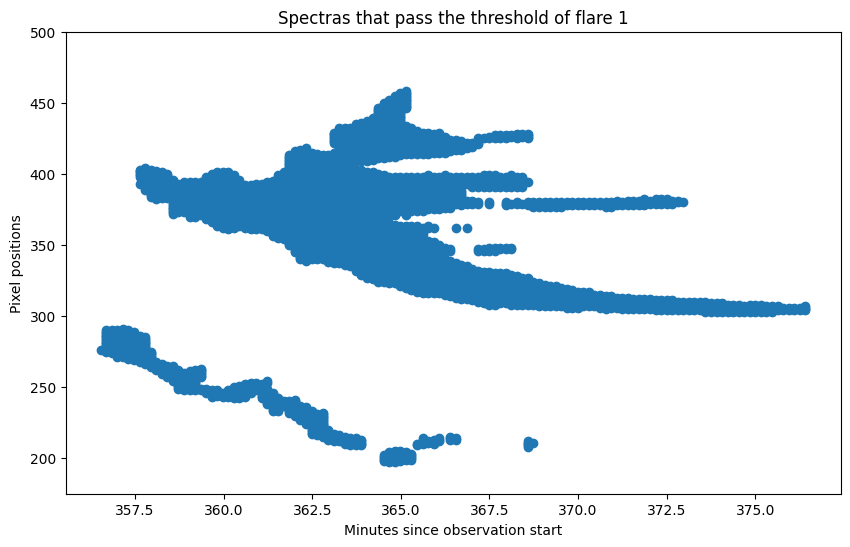

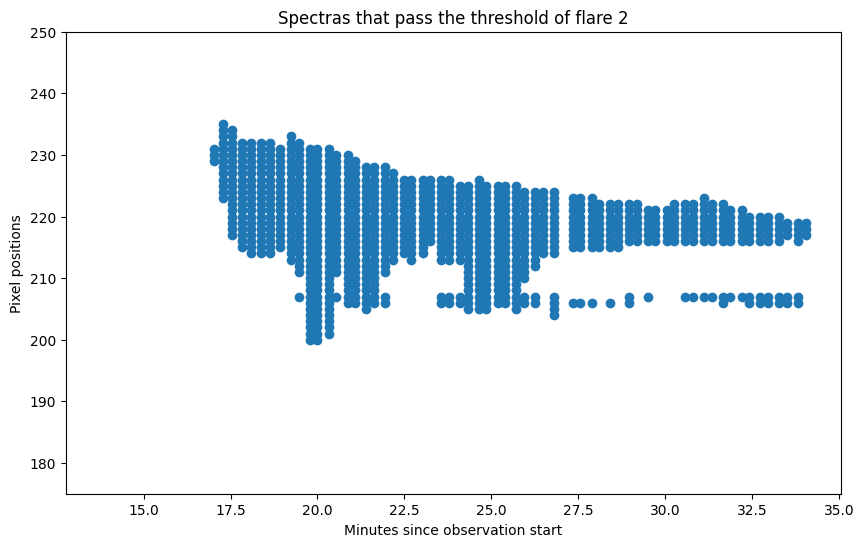

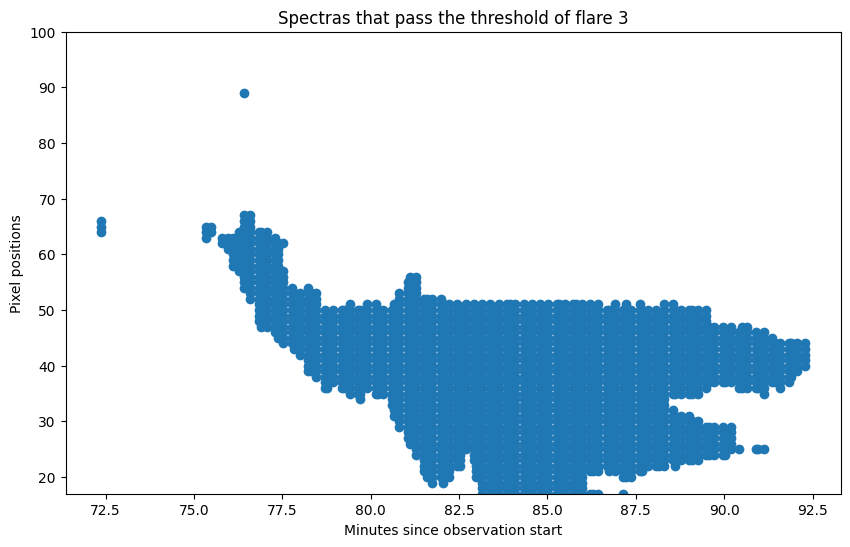

In [5]:
def Find_Pos2(obs, n, Time, t_start, t_end, y_start, y_end):
    hdrs = obs.raster("Mg II k").headers
    lambda_min = hdrs[0]["WAVEMIN"] + 0.00001
    lambda_max = hdrs[0]["WAVEMAX"] - 0.00001
    exptime = obs.raster("Mg II k").get_exptimes()
    a = obs.raster("Mg II k")
    t_range = list(range(t_start, t_end+1))
    #Extract intensity for each y pixel and t timestep
    Intensity = []
    Total = []
    for i in range(len(t_range)):
        t = t_range[i]
        intensity = []
        interpolated_image = a.get_interpolated_image_step( t, lambda_min, lambda_max, n_breaks=100 )
        for y in range(interpolated_image.shape[0]):
            b = interpolated_image[y]/exptime[t]
            intensity.append(sum(b))
            Total.append(sum(b))
        Intensity.append(intensity)
    Total.sort()
    threshold = Total[int(0.95*len(Total))]
    t_flare = []
    y_flare = []
    for i in range(len(t_range)):
        for y in range(a.shape[1]):
            if threshold <= Intensity[i][y]:
                #t_flare.append(t_range[i])
                t_flare.append(Time[t_range[i]])
                y_flare.append(y)
    plt.figure()
    plt.scatter(t_flare, y_flare)
    plt.xlabel('Minutes since observation start')
    plt.ylabel('Pixel positions')
    plt.ylim(y_start, y_end)
    plt.title('Spectras that pass the threshold of flare ' + str(n))
    #plt.ylim(0,a.shape[1])
    plt.show()
    


N = 1
for n in range(n_obs):
    path0 = "/sml/iris/" + str(path[n][0:4] + "/" + str(path[n][4:6]) + "/" + str(path[n][6:8]))
    os.chdir( path0)
    obs = observation(path[n],keep_null=True)
    Find_Pos2(obs, N, Time[n], t_start[n], t_end[n], y_start[n], y_end[n])
    obs.close()
    N+=1


In [13]:
#RealDeal

import os
import datetime
import irisreader as ir
from irisreader import observation
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from scipy.optimize import curve_fit
np.random.seed(1) # set the seed for reproducible results
ir.config.verbosity_level=0
import time
import random as rdm

def Data(obs, n, t_start, t_end, y_start, y_end, lambda_min, lambda_max): #Normalizes the spectra in the selected y and t range and combines flare spectra into a single array for clustering
    a = obs.raster("Mg II k")
    n_bins = 500
    exptime = a.get_exptimes()
    t_range = np.linspace(t_start, t_end, t_end - t_start + 1)
    y_range = np.linspace(y_start, y_end, y_end - y_start + 1)
    fl_spectra = np.zeros((t_range.shape[0]*y_range.shape[0] , n_bins))
    norm = []
    print(len(y_range)*len(t_range))
    print(len(y_range), len(t_range))
    #start1 = time.time()
    t_data = []
    y_data = []
    flare_number = []
    for y in range(len(y_range)):
        for t in range(len(t_range)):
            fl_spectra[t+y*len(t_range),:] = a.get_interpolated_image_step( int(t+np.min(t_range)), lambda_min, lambda_max, n_breaks=n_bins )[int(y+np.min(y_range))]/exptime[int(t+np.min(t_range))]
            t_data.append(t+t_start)
            y_data.append(y+y_start)
            flare_number.append(n)
    #end = time.time()
    #print(end - start, 'for organizing')
    norm = np.nanmax(fl_spectra, axis=1).reshape(fl_spectra.shape[0], 1)
    fl_spectra_norm = fl_spectra / norm
    # colors = ["#%06x" % rdm.randint(0, 0xFFFFFF) for _ in range(n_groups)]
    # colors = sort_colors_by_spectrum(hex_colors)
    
    # print("Sorted colors:")
    # for color in colors:
    #     print(color)
    cleaned_fl = []
    cleaned_t = []
    cleaned_y = []
    cleaned_norm = []
    for i in range(len(fl_spectra_norm)):
        if fl_spectra_norm[i][0] >= 0 or fl_spectra_norm[i][0] < 0:
            cleaned_fl.append(fl_spectra_norm[i])
            cleaned_t.append(t_data[i])
            cleaned_y.append(y_data[i])
            cleaned_norm.append(norm[i])
    fl_spectra_norm = cleaned_fl
    t_data = cleaned_t
    y_data = cleaned_y
    norm = cleaned_norm
    return norm, fl_spectra_norm, t_data, y_data, flare_number


t_data = []
y_data = []
norm = []
fl_spectra_norm = []
flare_number = []


lambda_min = np.max(lambda_min_list)
lambda_max = np.min(lambda_max_list)
if lambda_min < 2791.2:
    lambda_min = 2791.2

if lambda_max > 2806:
    lambda_max = 2806
n_bins = 500

print('Error of WL = '+str((lambda_max - lambda_min)/n_bins))
xax = np.linspace( lambda_min, lambda_max, n_bins )

n_obs = len(y_start)

for n in range(n_obs):
    print(n)
    path0 = "/sml/iris/" + str(path[n][0:4] + "/" + str(path[n][4:6]) + "/" + str(path[n][6:8]))
    os.chdir(path0)
    obs = observation(path[n],keep_null=True)
    a = obs.raster("Mg II k")
    

    if t_end[n] > a.shape[0]-1:
        t_end[n] = a.shape[0]-1
        t_start[n] = t_end[n]-400
        if t_start[n] < 0:
            t_start[n] = 0

    if y_end[n] > a.shape[1]-1:
        y_end[n] = a.shape[1]-1
        y_start[n] = y_end[n]-200
        if y_start[n] < 0:
            y_start[n] = 0

    norm0, fl_spectra_norm0, t_data0, y_data0, flare_number0 = Data(obs, n, t_start[n], t_end[n], y_start[n], y_end[n], lambda_min, lambda_max)
    norm = norm + norm0
    fl_spectra_norm = fl_spectra_norm +  fl_spectra_norm0
    flare_number = flare_number + flare_number0
    t_data.append(t_data0)
    y_data.append(y_data0)



Error of WL = 0.029600000000000362
0
34584
262 132


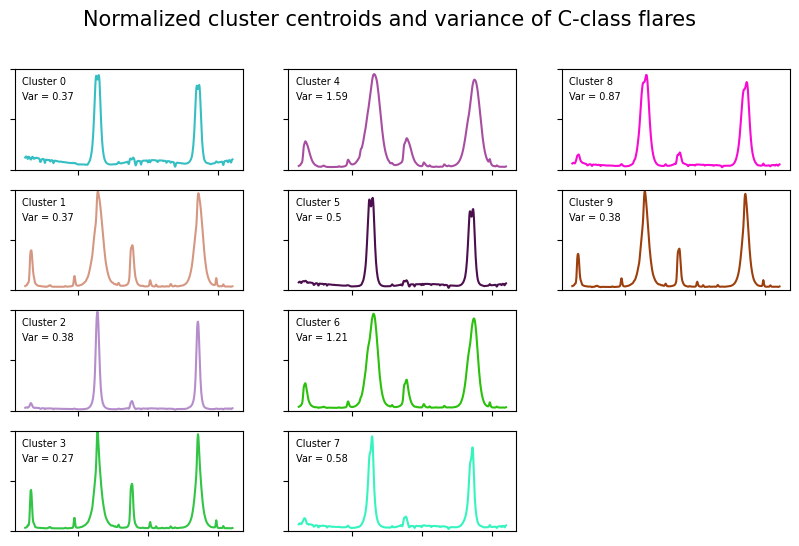

In [15]:
def Auto_KMeans(X, n_clusters, batch_size, n_init, verbose):
    #Applies KMeans algorithm to a random batch. More time efficient that applying to all flares of the batch
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=batch_size,
                              n_init=n_init, max_no_improvement=10, verbose=verbose)
    mbk.fit(X)
    centroids = mbk.cluster_centers_
    labels = mbk.labels_
    inertia = mbk.inertia_
    return centroids, labels, inertia, n_clusters

def Clustering(fl_spectra_norm, labels, centroids, xax, n_past):
    centroid = centroids[n_past:n_past+20]
    n_groups = len(centroid)
    index1 = int(np.sqrt(n_groups))
    index2 = int(n_groups/index1) + 1
    n = 0
    i1 = 0
    i2 = 0
    fig, ax = plt.subplots(index2, index1, dpi=100)
    #plt.title('Centroids of '+str(n_groups)+' Clusters')
    fig.set_dpi(100)
    fig.suptitle('Normalized cluster centroids and variance of C-class flares', fontsize=15)  
    while n < n_groups:
        counter = 0
        variance = 0
        for i in range(len(fl_spectra_norm)):
            if labels[i] == n +n_past:
                dist = 0
                counter += 1
                diff = fl_spectra_norm[i] - centroids[n,:]
                for j in range(len(diff)):
                    dist += diff[j]**2
                variance += dist
                #if counter%10 == 0:
                    #ax[i2, i1].plot(xax, fl_spectra_norm[i], 'grey', linewidth=0.1)
        ax[i2, i1].plot(xax, centroids[n+n_past,:], colors[n+n_past])
        ax[i2, i1].text(2791, 0.85, 'Cluster ' + str(n+n_past), fontsize = 7)
        ax[i2, i1].text(2791, 0.7, 'Var = '+str(round(variance/(counter - 1), 2)), fontsize = 7)
        ax[i2, i1].tick_params('x', labelbottom=False)
        ax[i2, i1].tick_params('y', labelleft=False)
        ax[i2, i1].set_ylim(0,1)
        i2 += 1
        n += 1
        if i2 == index2:
            i2 = 0
            i1 += 1
    while n < index1*index2:
        ax[i2, i1].remove()
        i2 += 1
        n += 1
        if i2 == index2:
            i2 = 0
            i1 += 1
    plt.show()


np.random.seed(int(time.time()))

n_groups = 10

colors = ["#%06x" % rdm.randint(0, 0xFFFFFF) for _ in range(n_groups)]

centroids, labels, inertia, n_clusters = Auto_KMeans(fl_spectra_norm, n_groups, 10000, 10, 0)

N=0
#index = 0
for n in range(int(n_groups/20)+1):
    Clusters = Clustering(fl_spectra_norm, labels, centroids, xax, N)
    #index = index + len(t_data[n])
    N += 20


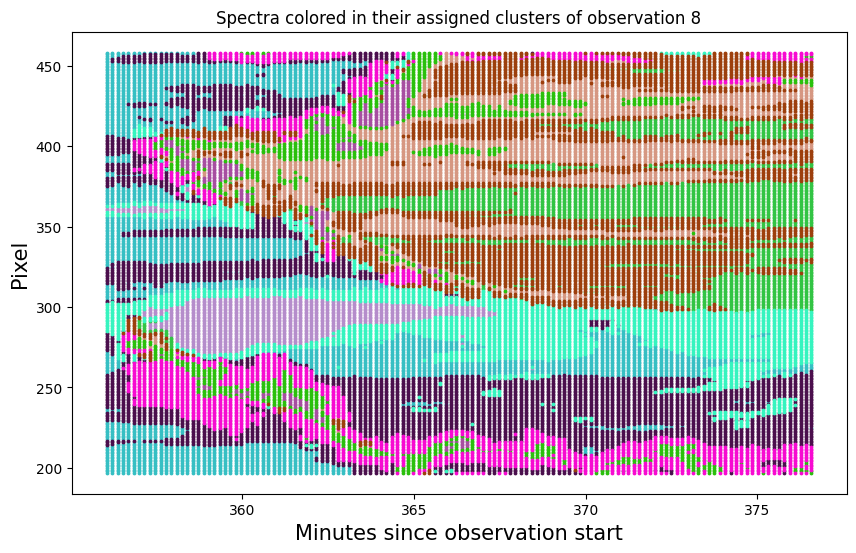

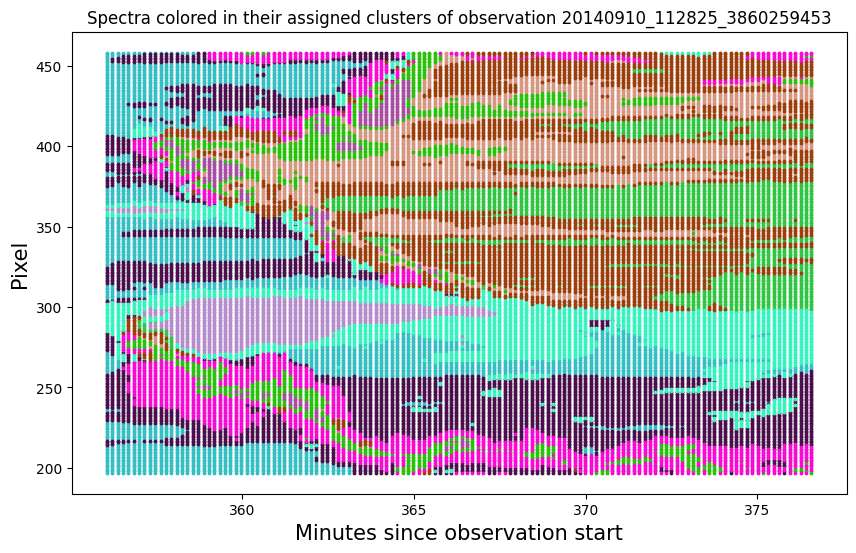

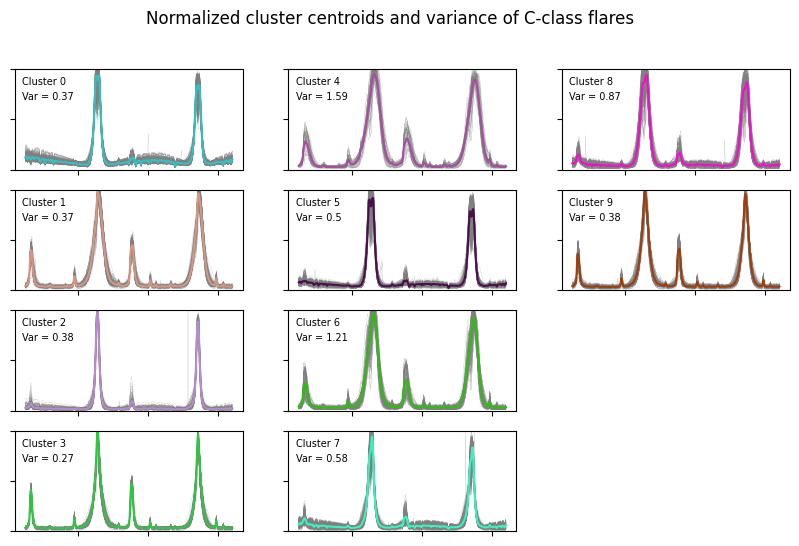

Cluster 1 has 5158 spectra
Cluster 2 has 4174 spectra
Cluster 3 has 1367 spectra
Cluster 4 has 3582 spectra
Cluster 5 has 590 spectra
Cluster 6 has 5849 spectra
Cluster 7 has 1920 spectra
Cluster 8 has 3514 spectra
Cluster 9 has 3039 spectra
Cluster 10 has 5391 spectra


In [19]:
def Plotting(path, Time, fl_spectra_norm, t_data, y_data, labels, n_groups):
    t_newlist = []
    y_newlist = []
    Timelist = []
    #start = time.time()
    for n in range(n_groups):
        templist_t = []
        templist_y = []
        Timelist_0 = []
        for i in range(len(t_data)):
                if labels[i] == n:
                    templist_t.append(t_data[i])
                    Timelist_0.append(Time[t_data[i]])
                    templist_y.append(y_data[i])
        t_newlist.append(templist_t)    
        y_newlist.append(templist_y) 
        Timelist.append(Timelist_0)    
    fl_new = []
    for n in range(n_groups):  
        fl_temp = []
        a1 = 0
        for i in range(len(fl_spectra_norm)):
            if labels[i] == n:
                fl_temp.append(fl_spectra_norm[i])
                a1 = a1 + 1
        fl_new.append(fl_temp)
    plt.figure(dpi=100)
    for n in range(n_groups):
        #plt.scatter(t_newlist[n], y_newlist[n], s = 3, color=colors[n], label='C'+str(n), )
        plt.scatter(Timelist[n], y_newlist[n], s = 3, color=colors[n], label='C'+str(n), )
    plt.title('Spectra colored in their assigned clusters of observation ' +str(path))
    #plt.xlabel('Timestep')
    plt.xlabel('Minutes since observation start', fontsize=15)
    plt.ylabel('Pixel', fontsize=15)
    #plt.legend()
    plt.show()

def Clustering(fl_spectra_norm, labels, centroids, xax, n_past):
    centroid = centroids[n_past:n_past+20]
    n_groups = len(centroid)
    index1 = int(np.sqrt(n_groups))
    index2 = int(n_groups/index1) + 1
    n = 0
    i1 = 0
    i2 = 0
    fig, ax = plt.subplots(index2, index1, dpi=100)
    #plt.title('Centroids of '+str(n_groups)+' Clusters')
    fig.set_dpi(100)
    fig.suptitle('Normalized cluster centroids and variance of C-class flares', fontsize=12)  
    while n < n_groups:
        counter = 0
        variance = 0
        for i in range(len(fl_spectra_norm)):
            if labels[i] == n +n_past:
                dist = 0
                counter += 1
                diff = fl_spectra_norm[i] - centroids[n,:]
                for j in range(len(diff)):
                    dist += diff[j]**2
                variance += dist
                if counter%10 == 0:
                    ax[i2, i1].plot(xax, fl_spectra_norm[i], 'grey', linewidth=0.1)
        ax[i2, i1].plot(xax, centroids[n+n_past,:], colors[n+n_past])
        ax[i2, i1].text(2791, 0.85, 'Cluster ' + str(n+n_past), fontsize = 7)
        ax[i2, i1].text(2791, 0.7, 'Var = '+str(round(variance/(counter - 1), 2)), fontsize = 7)
        ax[i2, i1].tick_params('x', labelbottom=False)
        ax[i2, i1].tick_params('y', labelleft=False)
        ax[i2, i1].set_ylim(0,1)
        i2 += 1
        n += 1
        if i2 == index2:
            i2 = 0
            i1 += 1
    while n < index1*index2:
        ax[i2, i1].remove()
        i2 += 1
        n += 1
        if i2 == index2:
            i2 = 0
            i1 += 1
    plt.show()

def Sorting(fl_spectra_norm, labels, centroids):
    fl_norm = []
    for n in range(len(centroids)):
        fl_temp = []
        for i in range(len(fl_spectra_norm)):
            if labels[i] == n:
                fl_temp.append(fl_spectra_norm[i])
        fl_norm.append(fl_temp)
        print('Cluster ' +str(n+1)+' has '+str(len(fl_temp)) +' spectra')
    return fl_norm


index = 0
flarenumber = 8
#offset = 0
for n in range(n_obs):
    fl_spectra_norm_temp = fl_spectra_norm[index:index+len(t_data[n])]
    Plotting(flarenumber, Time[n], fl_spectra_norm_temp, t_data[n], y_data[n], labels[index:index+len(t_data[n])], n_groups)
    #Plotting(path[n], Time[n], fl_spectra_norm_temp, t_data[n], y_data[n], labels[index:index+len(t_data[n])], n_groups)
    index = index + len(t_data[n])
    flarenumber += 1

N=0
#index = 0
for n in range(int(n_groups/20)+1):
    Clusters = Clustering(fl_spectra_norm, labels, centroids, xax, N)
    #index = index + len(t_data[n])
    N += 20


fl_norm = Sorting(fl_spectra_norm, labels, centroids)



In [15]:



'''

fl_norm_M = fl_norm
xax_M = xax
path_M = path
labels_M = labels
t_data_M = t_data
y_data_M = y_data
colors_M = colors
fl_spectra_norm_M = fl_spectra_norm
centroids_M = centroids
Time_M = Time

%store fl_norm_M
%store xax_M
%store path_M
%store labels_M
%store t_data_M
%store y_data_M
%store colors_M
%store fl_spectra_norm_M
%store centroids_M
%store Time_M


fl_norm_C = fl_norm
xax_C = xax
path_C = path
labels_C = labels
t_data_C = t_data
y_data_C = y_data
colors_C = colors
fl_spectra_norm_C = fl_spectra_norm
centroids_C = centroids
Time_C = Time

%store fl_norm_C
%store xax_C
%store path_C
%store labels_C
%store t_data_C
%store y_data_C
%store colors_C
%store fl_spectra_norm_C
%store centroids_C
%store Time_C

'''


Stored 'fl_norm_C' (list)
Stored 'xax_C' (ndarray)
Stored 'path_C' (list)
Stored 'labels_C' (ndarray)
Stored 't_data_C' (list)
Stored 'y_data_C' (list)
Stored 'colors_C' (list)
Stored 'fl_spectra_norm_C' (list)
Stored 'centroids_C' (ndarray)
Stored 'Time_C' (list)


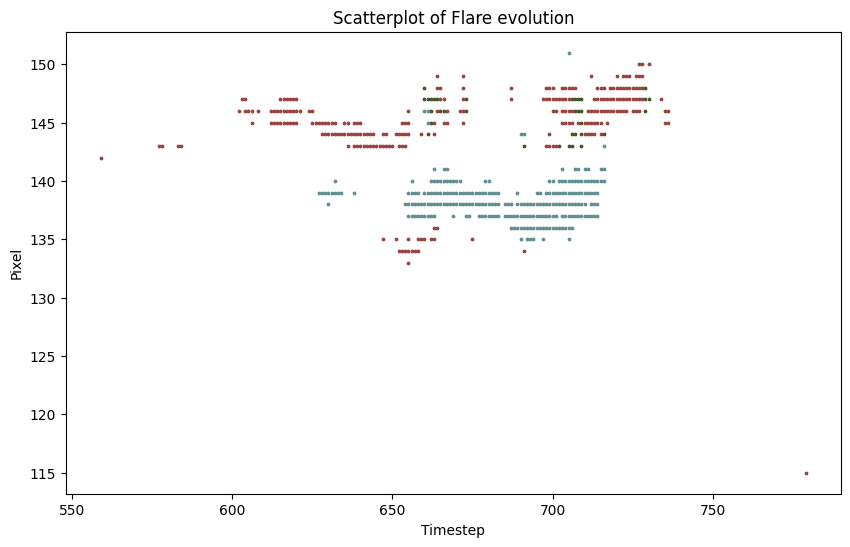

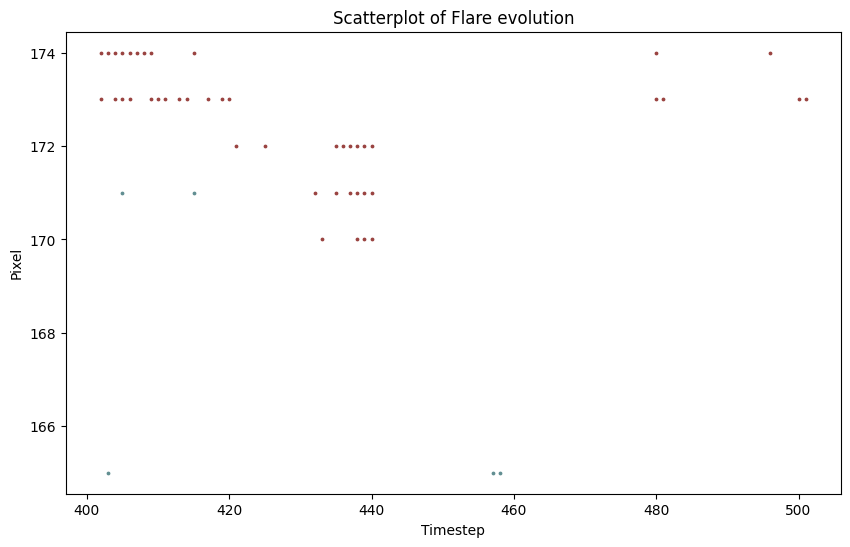

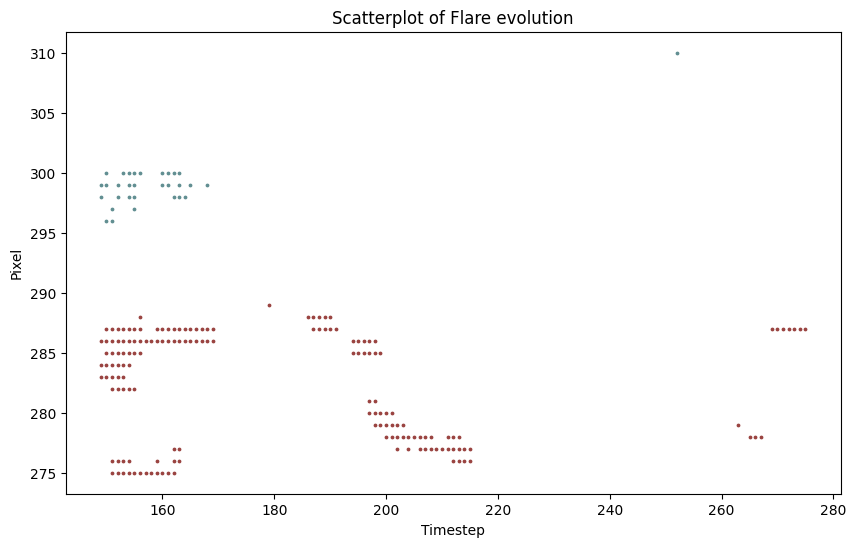

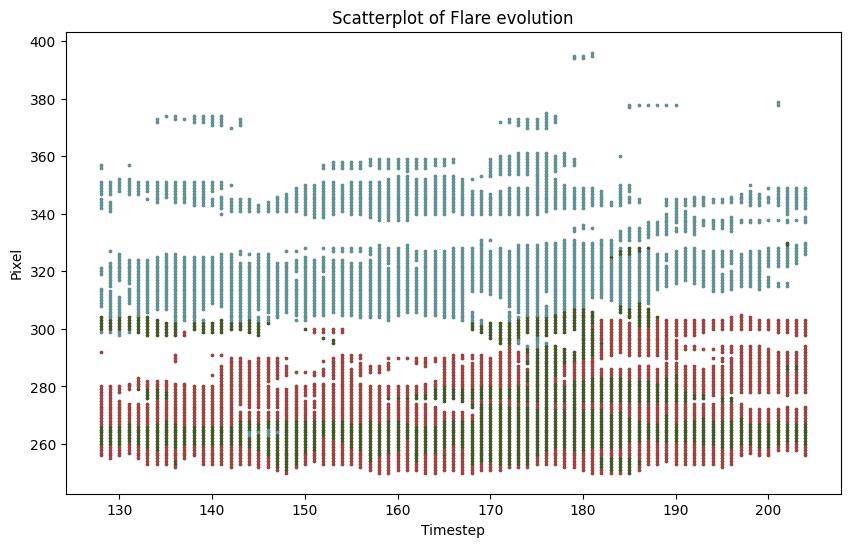

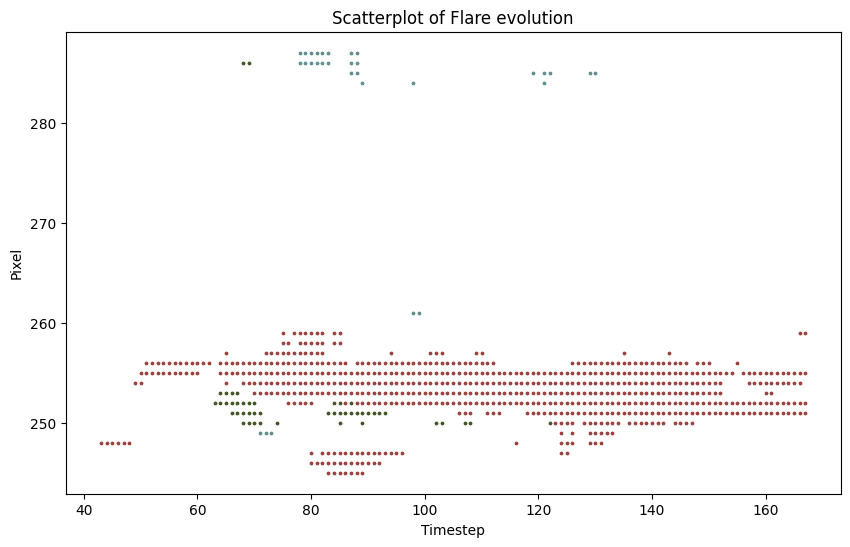

In [14]:
def Cluster_Plotting(Clusters, t_data, y_data, labels, n_groups):
    t_newlist = []
    y_newlist = []
    #start = time.time()
    for n in range(n_groups):
        templist_t = []
        templist_y = []
        for i in range(len(t_data)):
            if labels[i] == n:
                templist_t.append(t_data[i])
                templist_y.append(y_data[i])
        t_newlist.append(templist_t)    
        y_newlist.append(templist_y)  
    for c in range(len(Clusters)):
        n = Clusters[c]
        plt.scatter(t_newlist[n], y_newlist[n], color=colors[n], s=3, label='C'+str(n))
    plt.title('Scatterplot of Flare evolution')
    plt.xlabel('Timestep')
    plt.ylabel('Pixel')
    #plt.legend()
    plt.show()
    return t_newlist, y_newlist

#X-class
#Clusters = [1,3,5,6,9,11,13,18,19]
#Clusters = [1,2,4,5,7,8,9,11,13,14,16,17,18,19]

#M-class
#Clusters = [0,5,6,8,13,19]
#Clusters = [6,9,10,14,19]

#C-class
Clusters = [14,17,22]

index = 0
t_newlist = []
y_newlist = []
for n in range(n_obs):
    t_newlist0, y_newlist0 = Cluster_Plotting(Clusters, t_data[n], y_data[n], labels[index:index+len(t_data[n])], n_groups)
    t_newlist.append(t_newlist0)
    y_newlist.append(y_newlist0)
    index = index + len(t_data[n])
